# Statistical Decomposition for Satellite Images

Our purpose is to explore visualizations and the distributions of those images, and then finally, decompose them using PCA and Factorial Analysis.

In [1]:
# Modules

# File managing
import os
import re as regex
import shutil

# Set working dir
os.chdir('/home/adriel_martins/Documents/projects/stats-img-processing')

# Visualization and Image Processing
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import biplot

# Data Manipulation
import pandas as pd

# PCA
from sklearn.decomposition import PCA
# Factor Analysis
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer

## Loading images

In [2]:
def lowering_files(root_path):
    """
    Because the files from AWS Landsat comes all in uppercase we must lower it.
    """
    for f in os.listdir(root_path):
        f = root_path + '/' + f
        os.rename(f, f.lower())
    print(f'Lowered all files for {root_path}.')

lowering_files('data/aws_landsat')

Lowered all files for data.


In [3]:
def get_files(root_path):
    files = []
    for f in os.listdir(root_path):
        # Retrieving only .tif files
        if '.tif' in f and '.ovr' not in f:
            # Checking in files are of the channel b2 to b4
            rgb_file = regex.search('(b)[\d]', f)
            if rgb_file:
                f = root_path + '/' + f
                files.append(f)
    return files

channel_files = get_files('data/aws_landsat')
channel_files

['data/lc08_l1tp_139045_20170304_20170316_01_t1_b10.tif',
 'data/lc08_l1tp_139045_20170304_20170316_01_t1_b9.tif',
 'data/lc08_l1tp_139045_20170304_20170316_01_t1_b2.tif',
 'data/lc08_l1tp_139045_20170304_20170316_01_t1_b5.tif',
 'data/lc08_l1tp_139045_20170304_20170316_01_t1_b1.tif',
 'data/lc08_l1tp_139045_20170304_20170316_01_t1_b6.tif',
 'data/lc08_l1tp_139045_20170304_20170316_01_t1_b4.tif',
 'data/lc08_l1tp_139045_20170304_20170316_01_t1_b11.tif',
 'data/lc08_l1tp_139045_20170304_20170316_01_t1_b3.tif',
 'data/lc08_l1tp_139045_20170304_20170316_01_t1_b7.tif',
 'data/lc08_l1tp_139045_20170304_20170316_01_t1_b8.tif']

In [4]:
def create_img_dict(channel_files):
    """
    Create dictionary like "b2: img of b2".
    """
    channels_img = {}

    for c_file in channel_files:
        img = cv2.imread(c_file, -1)

        name_of_file = c_file[-6:-4]
        if not 'b' in name_of_file:
            name_of_file = 'b' + name_of_file

        channels_img.update({name_of_file: img})

    return channels_img

channels_dict = create_img_dict(channel_files)

In [5]:
def concatenate_channels(channels_dict, exclude_channels=[None]):
    channels_names = [i for i in channels_dict.keys() if i not in exclude_channels]
    channels_names.sort(key=lambda x: int(x.split('b')[1]))
    channels_imgs = [channels_dict[i] for i in channels_names]
    channels_imgs = tuple(channels_imgs)

    return np.dstack(channels_imgs)

sat = concatenate_channels(channels_dict, exclude_channels=['b8'])
print(sat.shape)
print(sat.dtype)
print(f'Maximum value for the pixel: {np.max(sat.flatten())}')

(7771, 7611, 10)
uint16
Maximum value for the pixel: 65535


## Cropping Figure

In [6]:
h = 500

x0 = 3500
x1 = x0 + h

y0 = 4500
y1 = y0 + h

sat_crop = np.zeros(shape=(h,h,sat.shape[2]))
for channel in range(0, sat.shape[2]):
    sat_crop[:, :, channel] = sat[x0:x1, y0:y1, channel]
    
sat = sat_crop

## Exploratory Data Analysis

In [7]:
sat_dict = {}
for channel in range(0, sat.shape[2]):
    channel_name = channel + 1
    if channel_name >= 8:
        channel_name += 1
    sat_dict.update({'b'+str(channel_name): sat[:,:,channel].flatten()})

df = pd.DataFrame.from_dict(sat_dict, orient='columns')
df['index'] = np.array(range(0, (df.shape[0])))
df

,b1,b2,b3,b4,b5,b6,b7,b9,b10,b11,index
0,11797.0,10866.0,9907.0,9229.0,13254.0,11461.0,8732.0,5031.0,28591.0,25865.0,0
1,11810.0,10898.0,9933.0,9404.0,13029.0,12277.0,9517.0,5042.0,28564.0,25830.0,1
2,11858.0,10977.0,10068.0,9704.0,13292.0,13226.0,10404.0,5059.0,28580.0,25857.0,2
3,11842.0,10957.0,10053.0,9670.0,12832.0,12994.0,10243.0,5057.0,28643.0,25934.0,3
4,11845.0,10959.0,10050.0,9671.0,13192.0,12669.0,10048.0,5044.0,28729.0,26017.0,4
...,...,...,...,...,...,...,...,...,...,...,...
249995,11603.0,10697.0,9896.0,9550.0,13257.0,12653.0,10196.0,5048.0,28889.0,26031.0,249995
249996,11525.0,10597.0,9796.0,9113.0,14050.0,11737.0,9198.0,5038.0,28983.0,26095.0,249996
249997,11556.0,10617.0,9790.0,9343.0,13285.0,12038.0,9563.0,5050.0,29088.0,26157.0,249997
249998,11563.0,10664.0,9889.0,9346.0,13628.0,11801.0,9408.0,5044.0,29200.0,26216.0,249998


In [8]:
def create_folder(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)
create_folder('data/output/array')
df.to_csv('data/output/array/cropped_img.csv')

In [9]:
df = df.melt(id_vars=["index"])
df

,index,variable,value
0,0,b1,11797.0
1,1,b1,11810.0
2,2,b1,11858.0
3,3,b1,11842.0
4,4,b1,11845.0
...,...,...,...
2499995,249995,b11,26031.0
2499996,249996,b11,26095.0
2499997,249997,b11,26157.0
2499998,249998,b11,26216.0


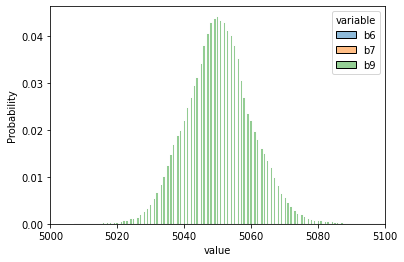

In [10]:
sns.histplot(data=df[df['value'] <= 6000], x='value', hue='variable', stat='probability')
plt.xlim((5000, 5100))
create_folder('data/output/img')
plt.savefig('data/output/img/eda_hist_2.png')

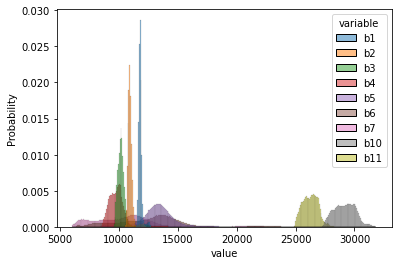

In [11]:
sns.histplot(data=df[df['value'] > 6000], x='value', hue='variable', stat='probability')
plt.savefig('data/output/img/eda_hist_1.png')

## PCA Analysis

In [12]:
df = df.pivot(index='index', columns='variable', values='value')
df

variable,b1,b10,b11,b2,b3,b4,b5,b6,b7,b9
index,,,,,,,,,,
0,11797.0,28591.0,25865.0,10866.0,9907.0,9229.0,13254.0,11461.0,8732.0,5031.0
1,11810.0,28564.0,25830.0,10898.0,9933.0,9404.0,13029.0,12277.0,9517.0,5042.0
2,11858.0,28580.0,25857.0,10977.0,10068.0,9704.0,13292.0,13226.0,10404.0,5059.0
3,11842.0,28643.0,25934.0,10957.0,10053.0,9670.0,12832.0,12994.0,10243.0,5057.0
4,11845.0,28729.0,26017.0,10959.0,10050.0,9671.0,13192.0,12669.0,10048.0,5044.0
...,...,...,...,...,...,...,...,...,...,...
249995,11603.0,28889.0,26031.0,10697.0,9896.0,9550.0,13257.0,12653.0,10196.0,5048.0
249996,11525.0,28983.0,26095.0,10597.0,9796.0,9113.0,14050.0,11737.0,9198.0,5038.0
249997,11556.0,29088.0,26157.0,10617.0,9790.0,9343.0,13285.0,12038.0,9563.0,5050.0


### Normalization

In [13]:
def stats(df):
    print('Mean of Columns:\n')
    display(df.mean())
    print('Std. Dev. of Columns:\n')
    display(df.std())

stats(df)

df=(df-df.mean())/df.std()

print('\n')
stats(df)

Mean of Columns:



variable
b1     11817.291212
b10    29196.351072
b11    26264.952468
b2     10948.185272
b3     10225.000512
b4      9855.851880
b5     13440.530704
b6     12655.372212
b7     10397.892800
b9      5050.385156
dtype: float64

Std. Dev. of Columns:



variable
b1      192.760962
b10     887.267230
b11     641.840973
b2      258.958874
b3      440.860891
b4      823.200569
b5     1403.974276
b6     2892.943615
b7     2736.677759
b9        9.692931
dtype: float64



Mean of Columns:



variable
b1     1.052518e-16
b10   -2.545218e-15
b11   -6.706966e-16
b2    -2.698668e-15
b3    -1.202562e-15
b4     1.307465e-16
b5    -8.780990e-17
b6    -9.088361e-16
b7     2.223435e-16
b9    -9.092658e-15
dtype: float64

Std. Dev. of Columns:



variable
b1     1.0
b10    1.0
b11    1.0
b2     1.0
b3     1.0
b4     1.0
b5     1.0
b6     1.0
b7     1.0
b9     1.0
dtype: float64

In [14]:
df.head()

variable,b1,b10,b11,b2,b3,b4,b5,b6,b7,b9
index,,,,,,,,,,
0,-0.105266,-0.682265,-0.623133,-0.317368,-0.721317,-0.761481,-0.132859,-0.412857,-0.608728,-1.999927
1,-0.037825,-0.712695,-0.677664,-0.193796,-0.662342,-0.548896,-0.293118,-0.130791,-0.321884,-0.865079
2,0.211188,-0.694662,-0.635597,0.111271,-0.356123,-0.184465,-0.105793,0.197248,0.002232,0.888776
3,0.128184,-0.623658,-0.515630,0.034039,-0.390147,-0.225767,-0.433434,0.117053,-0.056599,0.682440
4,0.143747,-0.526731,-0.386314,0.041762,-0.396952,-0.224553,-0.177019,0.004711,-0.127853,-0.658744


### PC estimation and exploration

In [15]:
pca = PCA(n_components=df.shape[1])
pca.fit(df)

PCA(n_components=10)

In [16]:
pca_comp = pd.DataFrame(pca.components_,
                        columns=['PC' + str(i) for i in range(1, df.shape[1] + 1)],
                        index=df.columns)

create_folder('data/output/latex_table')
pca_comp.to_latex('data/output/latex_table/pca_pc.txt', index=False)
pca_comp 

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
variable,,,,,,,,,,
b1,0.317347,0.297197,0.298769,0.341724,0.362918,0.380150,0.233071,0.362462,0.376506,0.035281
b10,0.443109,-0.498231,-0.497093,0.379027,0.281173,0.109792,0.039248,-0.188480,-0.142577,-0.127089
b11,0.076152,-0.033782,-0.029953,0.064878,0.040767,0.029629,-0.144191,-0.086673,-0.060648,0.976438
b2,-0.165716,-0.226449,-0.221468,-0.164924,-0.083926,-0.143950,0.848814,0.242522,0.095253,0.169914
b3,0.284582,0.346801,0.322844,0.154369,0.017089,-0.249758,0.404393,-0.429912,-0.509376,-0.013766
b4,0.485591,0.036777,-0.048136,0.215465,-0.543098,-0.482071,-0.129078,0.396982,0.111528,0.008015
b5,-0.111410,0.519450,-0.544640,0.085337,-0.125379,0.313306,-0.005533,0.309829,-0.451595,-0.001354
b6,-0.056834,-0.416726,0.404034,0.187690,-0.477314,0.510792,0.059017,0.136576,-0.337242,-0.005741
b7,-0.387899,-0.169535,0.178091,0.375913,0.407338,-0.408333,-0.114306,0.428629,-0.343972,0.000059


PC1: 0.6439 
PC2: 0.1467 
PC3: 0.099 
PC4: 0.0832 
PC5: 0.0159 
PC6: 0.0087 
PC7: 0.001 
PC8: 0.0007 
PC9: 0.0005 
PC10: 0.0004 


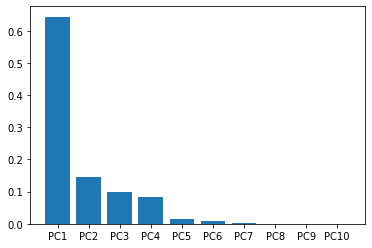

In [17]:
plt.bar(x=pca_comp.columns, height=pca.explained_variance_ratio_)
plt.savefig('data/output/img/pca_bar.png')

for index, elem in enumerate(pca.explained_variance_ratio_):
    print(f"PC{str(index + 1)}: {round(elem,4)} ")

In [18]:
score = pca.transform(df.values)
df_score = pd.DataFrame(score,
                        columns=['PC' + str(i) for i in range(1, df.shape[1] + 1)])
df_score

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.562415,0.609884,-1.899809,-0.078258,0.122494,0.413571,-0.028087,0.086845,-0.009167,0.033750
1,-1.208980,0.524218,-0.785919,0.026129,-0.267289,0.513689,0.005252,0.103105,-0.015590,0.011003
2,-0.411637,0.522821,0.911681,0.410430,-0.469799,0.513241,0.017641,0.132162,-0.009331,-0.002152
3,-0.570336,0.384522,0.748034,0.064857,-0.497465,0.493759,-0.013019,0.127144,0.029468,0.026811
4,-0.552427,0.491838,-0.590167,-0.033458,-0.210152,0.407038,-0.035174,0.174953,-0.023369,-0.000859
...,...,...,...,...,...,...,...,...,...,...
249995,-1.375408,-0.720279,-0.383280,0.459485,-0.635417,-0.153267,0.070941,0.063099,-0.051910,-0.009512
249996,-2.015455,-1.005404,-1.509943,0.832216,-0.048046,-0.302312,0.010768,-0.034135,0.009152,-0.034841
249997,-1.768111,-1.202350,-0.221547,0.491351,-0.338202,-0.198739,0.070891,0.040109,-0.085611,0.014750
249998,-1.562621,-1.050738,-0.833876,0.464015,-0.052082,-0.340831,0.070507,-0.022793,0.009888,-0.061552


In [19]:
df_score.to_csv('data/output/array/pca_score.csv')

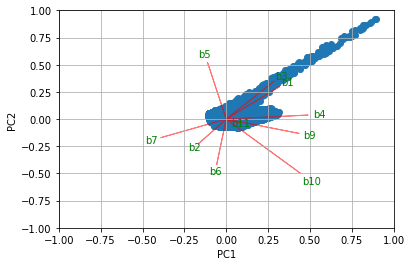

In [20]:
biplot(df_score.values,
       pca.components_,
       1,2,
       labels=df.columns)
plt.savefig('data/output/img/pca_biplot.png')

### Compressed Image through PCA

In [21]:
compressed_image = df_score['PC1'].to_numpy().copy()
print(compressed_image.shape)
compressed_image.shape = (500, -1)
print(compressed_image.shape)

(250000,)
(500, 500)


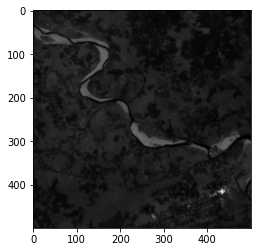

In [22]:
plt.imshow(compressed_image, cmap='gray')
plt.savefig('data/output/img/pca_compressed_image.png')
plt.show()

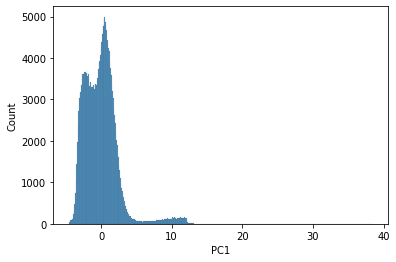

In [23]:
sns.histplot(data=df_score, x='PC1')
plt.savefig('data/output/img/pca_compressed_image_hist.png')

## Factorial Analysis

In [24]:
df

variable,b1,b10,b11,b2,b3,b4,b5,b6,b7,b9
index,,,,,,,,,,
0,-0.105266,-0.682265,-0.623133,-0.317368,-0.721317,-0.761481,-0.132859,-0.412857,-0.608728,-1.999927
1,-0.037825,-0.712695,-0.677664,-0.193796,-0.662342,-0.548896,-0.293118,-0.130791,-0.321884,-0.865079
2,0.211188,-0.694662,-0.635597,0.111271,-0.356123,-0.184465,-0.105793,0.197248,0.002232,0.888776
3,0.128184,-0.623658,-0.515630,0.034039,-0.390147,-0.225767,-0.433434,0.117053,-0.056599,0.682440
4,0.143747,-0.526731,-0.386314,0.041762,-0.396952,-0.224553,-0.177019,0.004711,-0.127853,-0.658744
...,...,...,...,...,...,...,...,...,...,...
249995,-1.111694,-0.346402,-0.364502,-0.969981,-0.746268,-0.371540,-0.130722,-0.000820,-0.073773,-0.246072
249996,-1.516340,-0.240459,-0.264789,-1.356143,-0.973097,-0.902395,0.434103,-0.317453,-0.438449,-1.277751
249997,-1.355519,-0.122118,-0.168192,-1.278911,-0.986707,-0.622997,-0.110779,-0.213406,-0.305075,-0.039736


In [25]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(df)
display(fa.loadings_)

array([[0.94681213, 0.12387987],
       [0.19370344, 0.92915095],
       [0.19574387, 0.93492442],
       [0.96323093, 0.21229673],
       [0.92414434, 0.33998778],
       [0.81899463, 0.52723959],
       [0.4152459 , 0.32890942],
       [0.54382131, 0.76099074],
       [0.60936102, 0.75527474],
       [0.02494798, 0.08875818]])

In [26]:
fa_comp = pd.DataFrame(fa.loadings_.tolist(),
                       index=df.columns,
                       columns=['F' + str(i) for i in range(1, fa.loadings_.shape[1] + 1)])
fa_comp.to_latex('data/output/latex_table/fa_full_pc.txt', index=False)
fa_comp

,F1,F2
variable,,
b1,0.946812,0.123880
b10,0.193703,0.929151
b11,0.195744,0.934924
b2,0.963231,0.212297
b3,0.924144,0.339988
b4,0.818995,0.527240
b5,0.415246,0.328909
b6,0.543821,0.760991
b7,0.609361,0.755275


In [27]:
def adjust_factors(col):
    col[abs(col) < 0.5] = 0
    return col

fa_comp = fa_comp.apply(adjust_factors).sort_values(by=['F1', 'F2'], ascending=False)
fa_comp.to_latex('data/output/latex_table/fa_adjusted_pc.txt', index=False)
fa_comp

,F1,F2
variable,,
b2,0.963231,0.000000
b1,0.946812,0.000000
b3,0.924144,0.000000
b4,0.818995,0.527240
b7,0.609361,0.755275
b6,0.543821,0.760991
b11,0.000000,0.934924
b10,0.000000,0.929151
b5,0.000000,0.000000


In [28]:
fa_var_comp = pd.DataFrame(fa.get_factor_variance(),
                       index=['SS Loadings', 'Proportion Var', 'Cumulative Var'],
                       columns=['F' + str(i) for i in range(1, fa.loadings_.shape[1] + 1)])
fa_var_comp.to_latex('data/output/latex_table/fa_var.txt')
fa_var_comp

,F1,F2
SS Loadings,4.265013,3.457001
Proportion Var,0.426501,0.345700
Cumulative Var,0.426501,0.772201


## Compressed image through FA

In [29]:
fa_score = pd.DataFrame(fa.transform(df),
                        columns=['F1', 'F2'])
fa_score

,F1,F2
0,-0.423327,-0.574774
1,-0.245363,-0.526909
2,0.122958,-0.489821
3,0.090803,-0.431901
4,-0.116046,-0.345796
...,...,...
249995,-0.936696,0.164351
249996,-1.161653,0.151110
249997,-1.452235,0.392258
249998,-0.933572,0.183353


In [30]:
fa_score.to_csv('data/output/array/fa_score.csv')

(250000,)
(500, 500)


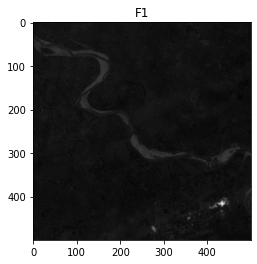

In [31]:
compressed_image = fa_score['F1'].to_numpy().copy()
print(compressed_image.shape)
compressed_image.shape = (500, -1)
print(compressed_image.shape)

plt.imshow(compressed_image, cmap='gray')
plt.title('F1')
plt.savefig('data/output/img/fa_1_compressed_image.png')
plt.show()

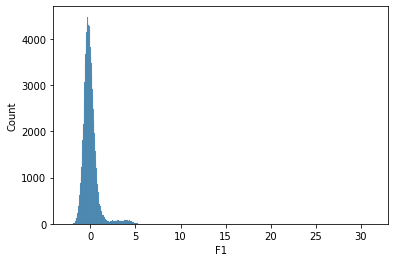

In [32]:
sns.histplot(fa_score, x='F1')
plt.savefig('data/output/img/fa_1_compressed_image_hist.png')

(250000,)
(500, 500)


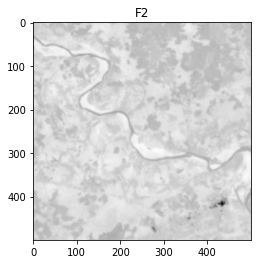

In [33]:
compressed_image = fa_score['F2'].to_numpy().copy()
print(compressed_image.shape)
compressed_image.shape = (500, -1)
print(compressed_image.shape)

plt.imshow(compressed_image, cmap='gray')
plt.title('F2')
plt.savefig('data/output/img/fa_2_compressed_image.png')
plt.show()

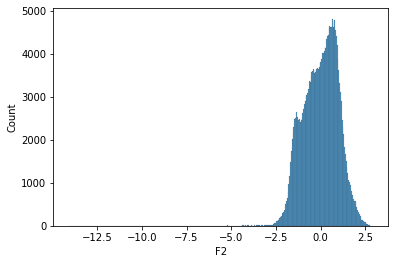

In [34]:
sns.histplot(fa_score, x='F2')
plt.savefig('data/output/img/fa_2_compressed_image_hist.png')